In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

### Use BeautifulSoup to pull in data from provided URL

In [2]:
# URL to scrape
url = 'https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/Immunization/measles.aspx'
# Response from url whether it was sucessful or not
response = requests.get(url)
# The actual html of the page
html = response.content
# Parse the html with BeautifulSoup
soup = BeautifulSoup(html,"html.parser")
# Find the table tag in the parsed html
table = soup.find('table')

### Loop over the table and pull out necessary data 

In [3]:
# Empty list to hold extracted row data
list_of_rows = []

# Loop through and find all the 'tr' tags in the table html
for row in table.findAll('tr')[:]:
    # Empty list to hold individual cell data
    list_of_cells = []
    # Loop through and find all the 'td' tags in the table html
    for cell in row.findAll('td'):
        # Replace the unicode charcters with nothing
        text = cell.text.replace(u'\u200b', '')
        # Add cleaned up text to empty list_of_cells list
        list_of_cells.append(text)
    # Add the list_of_cells list to the list_of_rows list
    list_of_rows.append(list_of_cells)

### Take a peek at the list_of_rows list of lists

In [4]:
list_of_rows

[['\nCounty',
  'Total Cases',
  'Pediatric Cases (<18 Years)',
  'Adult Cases (18 Years or Older)'],
 ['Alameda*', '1', '0', '1'],
 ['Los Angeles*', '22', '3†', '19'],
 ['Orange', '5', '2', '3'],
 ['Placer', '3', '2', '1'],
 ['Sacramento', '3', '2', '1'],
 ['San Bernardino', '2', '1', '1'],
 ['San Diego', '2', '1', '1'],
 ['San Francisco', '1', '0', '1'],
 ['San Mateo', '6', '1', '5'],
 ['Santa Barbara', '2', '0', '2'],
 ['Santa Clara', '5', '1', '4'],
 ['Santa Cruz', '1', '0', '1'],
 ['Other§', '19', '3', '16'],
 ['Total', '72', '16', '56']]

### Create data frame from list

In [5]:
measles = pd.DataFrame(list_of_rows)

### Make the first row the header row

In [6]:
measles = measles.rename(columns=measles.iloc[0])

### Drop the first index row since we won't need it anymore

In [7]:
measles = measles.drop(measles.index[0])

### Rename columns

In [12]:
# Doesn't seem to work anymore 12/18/19
#measles.rename(columns={'County' : 'county', 'Total\r\nCases' : 'total', 'Pediatric\r\nCases (<18 Years)' : 'pediatric', 'Adult\r\nCases (18 Years or Older)' : 'adult'}, inplace=True)
measles.columns = ['county', 'total', 'pediatric', 'adult']

In [13]:
# Clean up a few values in our columns
measles['pediatric'].replace('3†','3', inplace=True)
measles['county'] = measles['county'].str.replace(r'\*$','')
measles['county'] = measles['county'].str.replace(r'§$','')

### Take a look at column types for the data frame

In [14]:
measles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 1 to 14
Data columns (total 4 columns):
county       14 non-null object
total        14 non-null object
pediatric    14 non-null object
adult        14 non-null object
dtypes: object(4)
memory usage: 560.0+ bytes


In [15]:
measles

,county,total,pediatric,adult
1,Alameda,1,0,1
2,Los Angeles,22,3,19
3,Orange,5,2,3
4,Placer,3,2,1
5,Sacramento,3,2,1
6,San Bernardino,2,1,1
7,San Diego,2,1,1
8,San Francisco,1,0,1
9,San Mateo,6,1,5
10,Santa Barbara,2,0,2


### Convert case count columns to numeric instead of string

In [16]:
# Convert case count columns to numeric instead of string; using apply
#cols = ['total', 'pediatric', 'adult']
#%timeit df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# # Convert case count columns to numeric instead of string; using list comprhension
measles[['total', 'pediatric', 'adult']] = pd.concat([measles[col].astype(int) for col in measles[['total', 'pediatric', 'adult']]],1)

### Make sure column types have changed

In [17]:
measles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 1 to 14
Data columns (total 4 columns):
county       14 non-null object
total        14 non-null int32
pediatric    14 non-null int32
adult        14 non-null int32
dtypes: int32(3), object(1)
memory usage: 392.0+ bytes


### Output data to csv file

In [18]:
measles.to_csv('./data/output/measlesCases.csv', index=False)

### Read in CA GeoJSON

In [19]:
cali = gpd.read_file('./data/caCountiesNoChannelIslands.geojson')

In [20]:
cali.head()

,COUNTYNS,GEOID,NAME,ALAND,AWATER,geometry
0,00277302,06075,San Francisco,121485107,479107241,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098..."
1,00277320,06111,Ventura,4773302741,946030569,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737..."
2,00277300,06071,San Bernardino,51948123813,123845007,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911..."
3,00277286,06043,Mariposa,3752472156,36225644,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925..."
4,01692767,06103,Tehama,7638228772,33767784,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607..."


### Quick peek at a plot of the GeoJSON

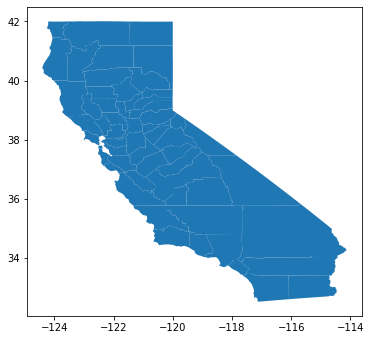

In [21]:
cali.plot(figsize=(6, 6))

### Drop some columns we don't need and set headers to all lowercase

In [22]:
cali = cali.drop(['COUNTYNS', 'GEOID', 'ALAND','AWATER'], axis=1)
cali = cali.rename(str.lower, axis=1)

### Merge our cali (GeoJSON) and measles_df (scraped data) data frames

In [23]:
merged_mmr = cali.set_index('name').join(measles.set_index('county'))

In [24]:
merged_mmr.head()

,geometry,total,pediatric,adult
name,,,,
San Francisco,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098...",1.0,0.0,1.0
Ventura,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737...",NaN,NaN,NaN
San Bernardino,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911...",2.0,1.0,1.0
Mariposa,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925...",NaN,NaN,NaN
Tehama,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607...",NaN,NaN,NaN


### Read in the vax rates file which was produced in the measlesVaxRates notebook

In [25]:
vax_rate = pd.read_csv('./data/output/mmr2_vax_rates.csv')

In [26]:
vax_rate.head()

,county,mmr2_pct
0,Alameda,98.1
1,Alpine,0.0
2,Amador,95.7
3,Butte,96.3
4,Calaveras,91.8


### Merge the vax_rate data frame with the previously merged (cali + measles) data frame 

In [27]:
merged_mmr = merged_mmr.join(vax_rate.set_index('county'))

In [28]:
merged_mmr.head()

,geometry,total,pediatric,adult,mmr2_pct
name,,,,,
San Francisco,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098...",1.0,0.0,1.0,97.3
Ventura,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737...",NaN,NaN,NaN,97.2
San Bernardino,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911...",2.0,1.0,1.0,97.1
Mariposa,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925...",NaN,NaN,NaN,94.9
Tehama,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607...",NaN,NaN,NaN,95.9


### Fill in all the NaNs in the merged_mmr data frame with zeroes

In [30]:
# Can't use across whole data frame as of geopandas 0.6, worked in older versions
#merged_mmr = merged_mmr.fillna(0)
# Have to fill NaN in data frame by specifying each column
merged_mmr = merged_mmr.fillna({'total' : 0, 'pediatric': 0, 'adult': 0})

In [31]:
merged_mmr.head()

,geometry,total,pediatric,adult,mmr2_pct
name,,,,,
San Francisco,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098...",1.0,0.0,1.0,97.3
Ventura,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737...",0.0,0.0,0.0,97.2
San Bernardino,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911...",2.0,1.0,1.0,97.1
Mariposa,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925...",0.0,0.0,0.0,94.9
Tehama,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607...",0.0,0.0,0.0,95.9


### Create a point data frame from our merged_mmr data frame which will be used to create bubble markers on a map

In [32]:
merged_mmr_pt = merged_mmr.copy()
merged_mmr_pt["geometry"] = merged_mmr_pt.centroid

### Fill in the NaNs in the merged_mmr_pt data frame with zeroes

In [34]:
# Can't use across whole data frame as of geopandas 0.6, worked in older versions
#merged_mmr_pt = merged_mmr_pt.fillna(0)
# Have to fill NaN in data frame by specifying each column
merged_mmr_pt = merged_mmr_pt.fillna({'total' : 0, 'pediatric': 0, 'adult': 0})

In [35]:
merged_mmr_pt.head()

,geometry,total,pediatric,adult,mmr2_pct
name,,,,,
San Francisco,POINT (-122.44087 37.75513),1.0,0.0,1.0,97.3
Ventura,POINT (-119.07823 34.47159),0.0,0.0,0.0,97.2
San Bernardino,POINT (-116.17839 34.84139),2.0,1.0,1.0,97.1
Mariposa,POINT (-119.90543 37.58151),0.0,0.0,0.0,94.9
Tehama,POINT (-122.23406 40.12563),0.0,0.0,0.0,95.9


### Change the data type of the measles cases columns to int from float for both data frames

In [36]:
merged_mmr_pt[["total", "pediatric", "adult"]] = merged_mmr_pt[["total", "pediatric", "adult"]].astype(int)
merged_mmr[["total", "pediatric", "adult"]] = merged_mmr[["total", "pediatric", "adult"]].astype(int)

In [37]:
merged_mmr.head()

,geometry,total,pediatric,adult,mmr2_pct
name,,,,,
San Francisco,"MULTIPOLYGON (((-122.51448 37.78083, -122.5098...",1,0,1,97.3
Ventura,"MULTIPOLYGON (((-119.47784 34.37942, -119.4737...",0,0,0,97.2
San Bernardino,"MULTIPOLYGON (((-117.80254 33.97555, -117.7911...",2,1,1,97.1
Mariposa,"MULTIPOLYGON (((-120.39442 37.67504, -120.3925...",0,0,0,94.9
Tehama,"MULTIPOLYGON (((-123.06543 40.28697, -123.0607...",0,0,0,95.9


In [38]:
merged_mmr_pt.head()

,geometry,total,pediatric,adult,mmr2_pct
name,,,,,
San Francisco,POINT (-122.44087 37.75513),1,0,1,97.3
Ventura,POINT (-119.07823 34.47159),0,0,0,97.2
San Bernardino,POINT (-116.17839 34.84139),2,1,1,97.1
Mariposa,POINT (-119.90543 37.58151),0,0,0,94.9
Tehama,POINT (-122.23406 40.12563),0,0,0,95.9


### Create our map

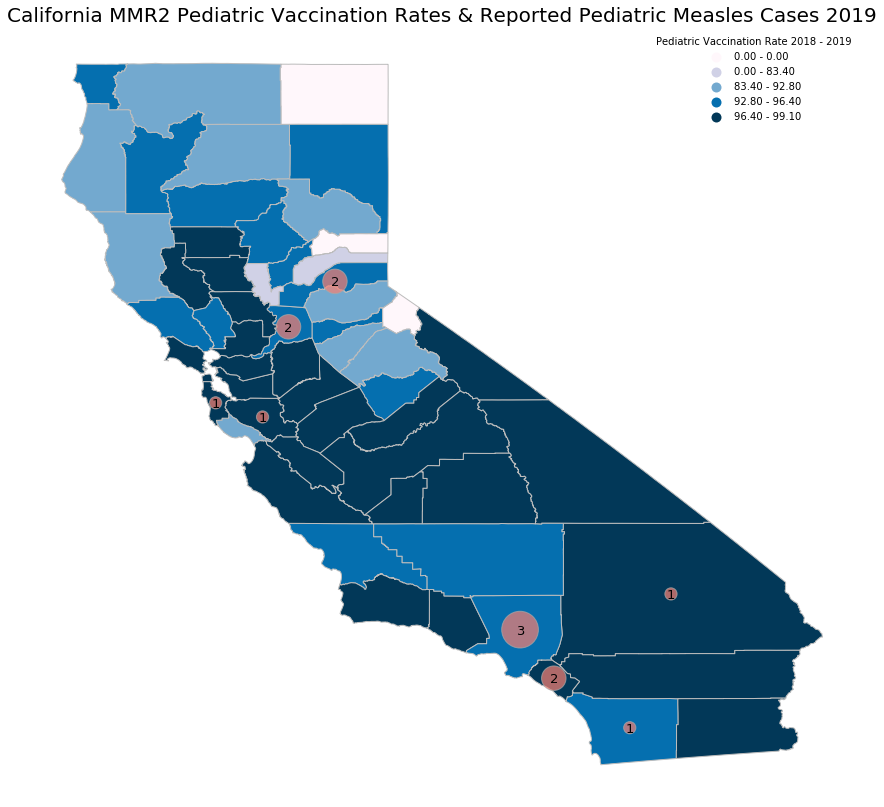

In [39]:
# Empty list to hold labels for bubble markers
markerLabels =[]

# Base map of vax rates
basemap = merged_mmr.plot(column='mmr2_pct', cmap='PuBu', figsize=(15,15), scheme='fisher_jenks', edgecolor='#bdbdbd', legend=True, 
                          legend_kwds={'title' : 'Pediatric Vaccination Rate 2018 - 2019','frameon' : False})

# Add pediatric cases to map as circles 
merged_mmr_pt.plot(ax = basemap, markersize = merged_mmr['pediatric']**2 * 150, color = "salmon", edgecolor = "darkgray", alpha = 0.7)

# Turn off axis
basemap.set_axis_off()

# Title For Map
plt.title('California MMR2 Pediatric Vaccination Rates & Reported Pediatric Measles Cases 2019' , fontsize=20);

# Use zip to iterate over the x/y of geometry and the pediatric column
for x, y, label in zip(merged_mmr_pt.geometry.x, merged_mmr_pt.geometry.y, merged_mmr_pt['pediatric']):
    if label != 0:
        markerLabels.append(plt.text(x,y,label, fontsize=13, horizontalalignment='center', verticalalignment='center_baseline'))